In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("water_waves_training_data.csv", sep=",")
data.head()

,height,wave_length,speed
0,78599.688827,1927.337789,54.855918
1,3508.728292,15221.672338,145.873054
2,86448.282139,16151.549318,158.800426
3,91334.040209,47468.784789,272.237925
4,77957.635081,29367.526137,214.130362


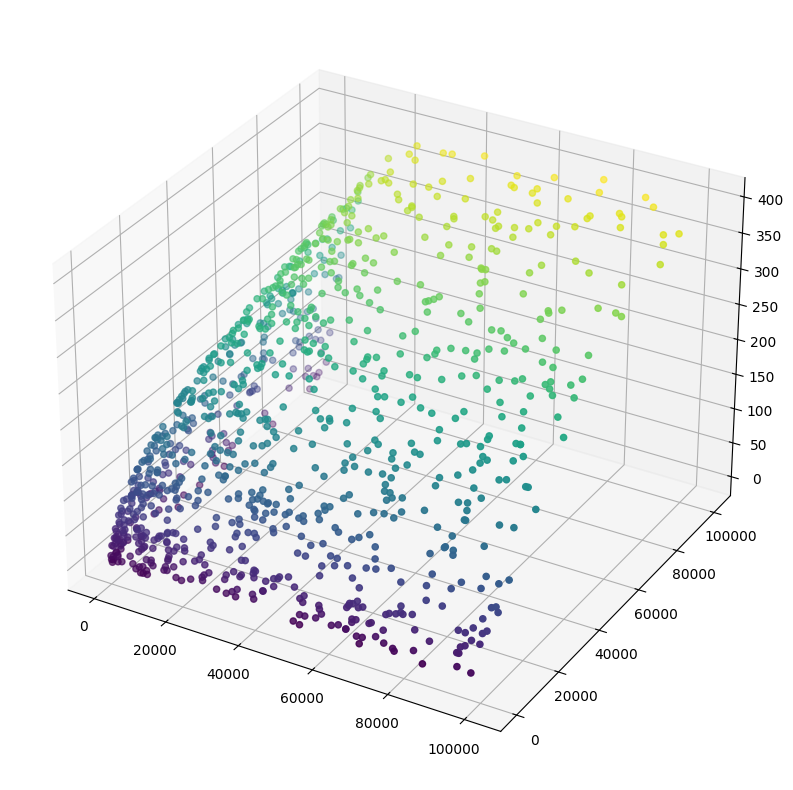

In [2]:
def linear_network(x0, x1, W, eps=1e-16):
    f = W[0]*x0 + W[1]*x1 + eps
    return x0/f, x1/f, f

# Create a general figure showing the data in 3d
plt.figure(figsize = [10, 10])
ax = plt.axes(projection='3d')
ax.scatter3D(data["height"], data["wave_length"], data["speed"], c=data["speed"], cmap='viridis')


In [32]:
# Create a dataset where height is always bigger then wave length, and if they are not swap their positions. The names have been replaced by x0 and x1 as their initial meaning is lost. Keep the speed as x2.

data_swapped = data.copy()
data_swapped["x0"] = np.maximum(data["height"], data["wave_length"])
data_swapped["x1"] = np.minimum(data["height"], data["wave_length"])
data_swapped["x2"] = data["speed"]
data_swapped_scaled = data_swapped.div

data_heightmorewavelength = data[data["height"] >= data["wave_length"]]
# Reset the index of the data_heightmorewavelength
data_heightmorewavelength = data_heightmorewavelength.reset_index(drop=True)
data_wavelengthmoreheight = data[data["height"] <= data["wave_length"]]
# Reset the index of the data_wavelengthmoreheight
data_wavelengthmoreheight = data_wavelengthmoreheight.reset_index(drop=True)

# Rename the columns of the data_heightmorewavelength and data_wavelengthmoreheight to x0, x1, and x2 due to the requirements of a few functions
data_heightmorewavelength = data_heightmorewavelength.rename(columns={"height": "x0", "wave_length": "x1", "speed": "x2"})
data_wavelengthmoreheight = data_wavelengthmoreheight.rename(columns={"height": "x0", "wave_length": "x1", "speed": "x2"})

data_heightmorewavelength.head()
data_wavelengthmoreheight.head()

,x0,x1,x2
0,3508.728292,15221.672338,145.873054
1,1365.584828,2101.861004,57.269444
2,4.252167,72854.851619,6.458619
3,5271.760991,36648.125655,202.711998
4,17495.768048,17836.902268,166.879258


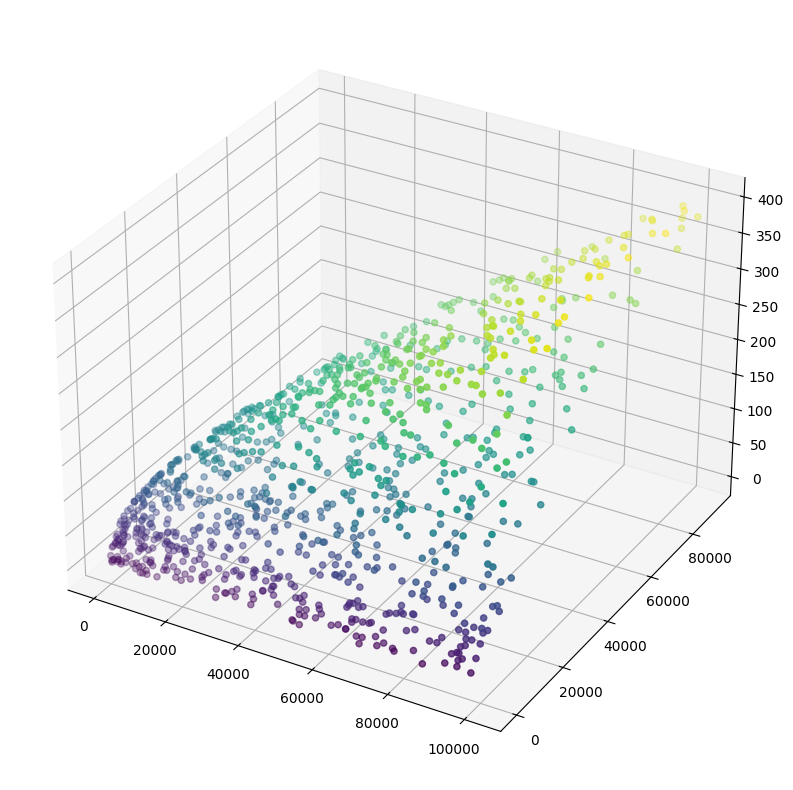

In [27]:

plt.figure(figsize = [10, 10])
ax = plt.axes(projection='3d')
ax.scatter3D(data_swapped["x0"], data_swapped["x1"], data_swapped["x2"], c=data_swapped["x2"], cmap='viridis')


In [4]:
# Fit a line to the data
def linear_network(x0, x1, W, x2=np.empty , eps=1e-16):
    f = W[0]*x0 + W[1]*x1 + eps
    if x2.size == 0:
        return x0/f, x1/f, f
    else:
        mape = 100 * np.mean(np.abs( f/x2 - 1))
        return x0/f, x1/f, f, mape
    

def fit_and_validate(weights, data, data_scaled, network):
    """
    input:
    weights      array of weights
    data         input data
    data_scaled  rescaled input data
    network      a function e.g. "linear_network" implemented above
    
    output: the MAPE value corresponding to the given input.
    """  
    #################################################################
    # Evaluate network and compute error
    n, m, f , mape = network(data["x0"], data["x1"], weights, data["x2"])
    # mape    = 100 * np.mean(np.abs( f.values/data["x2"].values - 1))
    #################################################################
    
    
    #################################################################
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
    
    #################################################################
    # plot scaled data
    ax1.scatter(data_scaled.x0, data_scaled.x1, color='r', label='Data')
    # fitting on the scaled data
    ax1.scatter(n, m, marker="x", label="Prediction")
    ax1.legend()
    #################################################################
    
    #################################################################
    # verification on the actual data
    ax2.loglog(data.x2, f, marker="x", ls='', label="Prediction")
    # diagonal line    
    z = [data.x2.min(), data.x2.max()]
    ax2.plot(z, z, color='r', label = "f(x,y)=d")
    # Report Error in the plot title
    ax2.set_title(f"MAPE = {mape:.2f} %" )
    ax2.set_xlabel("Reference")
    ax2.set_ylabel("Prediction")
    ax2.legend()
    #################################################################
    
    return mape

%matplotlib inline
import ipywidgets as ip

mape_list = []

def interactive_fit(w0, w1):
    
    fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(12,5) )
    
    n, m, f , mape = linear_network(data_swapped["x0"], data_swapped["x1"], [w0, w1], data_swapped["x2"])
    mape_list.append(mape)
    
    ax1.loglog(data_swapped.x2, f, marker="x", ls='', label="Prediction")
    
    z = [data_swapped.x2.min(), data_swapped.x2.max()]
    ax1.plot(z, z, '-r')
    
    ax1.set_title(f"MAPE = {mape:.2f} %" )
    ax1.set_xlabel('Reference')
    ax1.set_ylabel('Prediction')    
    
    
    ax2.semilogy( np.arange( len(mape_list) ), mape_list, 'o--')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAPE') 
    



ip.interact(interactive_fit, w0=(-0.10, 0.10, 0.001), w1=(-0.10, 0.10, 0.001));
# coef = np.polyfit(data_swapped["x0"], data_swapped["x1"], 1)
# poly1d_fn = np.poly1d(coef)
# 
# plt.plot(data_swapped["x0"], data_swapped["x1"], '.', data_swapped["x0"], poly1d_fn(data_swapped["x0"]), '-')

interactive(children=(FloatSlider(value=0.0, description='w0', max=0.1, min=-0.1, step=0.001), FloatSlider(val…

Minimum MAPE value is 56.77561758644002 at w0 = 0.0 and w1 = 0.008999999999999994


56.77561758644002

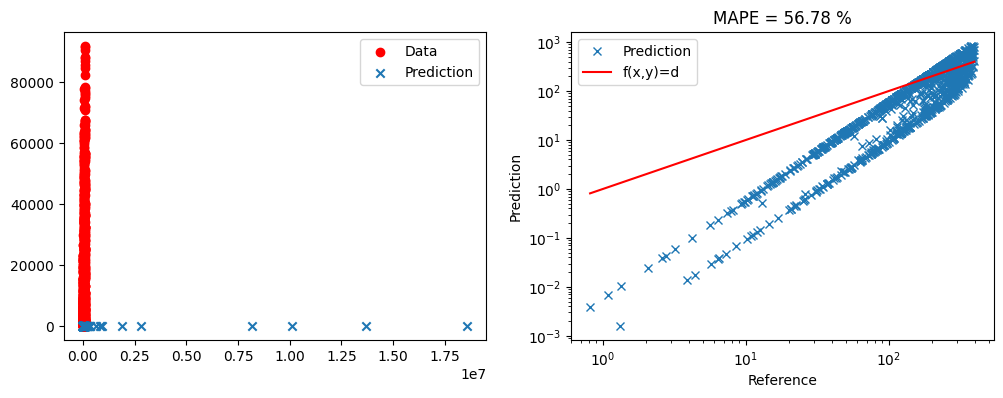

In [5]:
mape_matrix = np.zeros((200, 200))
for i in range(200):
    for j in range(200):
        mape_matrix[i, j] = linear_network(data_swapped["x0"], data_swapped["x1"], [i/1000 - 0.1, j/1000 - 0.1], data_swapped["x2"])[3]
        
# Get the coordinates of the minimum value of mape
min_mape = np.where(mape_matrix == np.min(mape_matrix))
print(f"Minimum MAPE value is {np.min(mape_matrix)} at w0 = {min_mape[0][0]/1000 - 0.1} and w1 = {min_mape[1][0]/1000 - 0.1}")

fit_and_validate([min_mape[0][0]/1000 - 0.1, min_mape[1][0]/1000 - 0.1], data_swapped, data_swapped, linear_network)

Minimum MAPE value is 50.13860833803799 at w0 = 0.0 and w1 = 0.007999999999999993


50.13860833803799

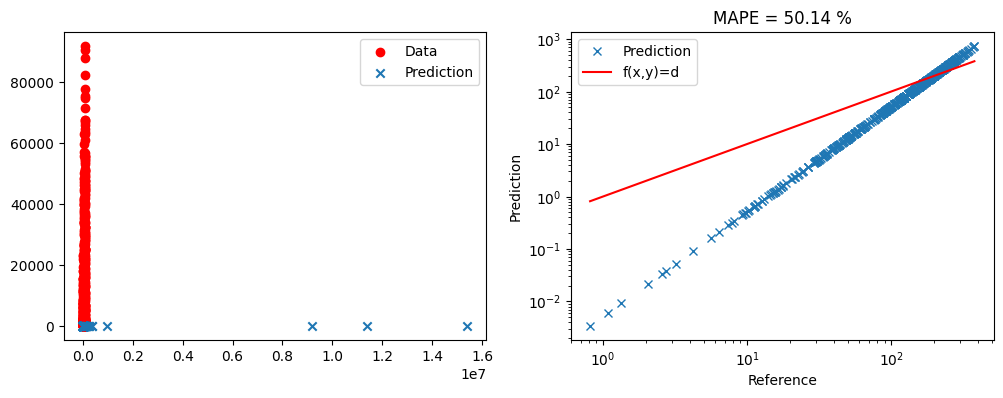

In [34]:
mape_matrix_heightmorewavelength = np.zeros((200, 200))
for i in range(200):
    for j in range(200):
        mape_matrix_heightmorewavelength[i, j] = linear_network(data_heightmorewavelength["x0"], data_heightmorewavelength["x1"], [i/1000 - 0.1, j/1000 - 0.1], data_heightmorewavelength["x2"])[3]
        
min_mape_heightmorewavelength = np.where(mape_matrix_heightmorewavelength == np.min(mape_matrix_heightmorewavelength))
print(f"Minimum MAPE value is {np.min(mape_matrix_heightmorewavelength)} at w0 = {min_mape_heightmorewavelength[0][0]/1000 - 0.1} and w1 = {min_mape_heightmorewavelength[1][0]/1000 - 0.1}")
fit_and_validate([min_mape_heightmorewavelength[0][0]/1000 - 0.1, min_mape_heightmorewavelength[1][0]/1000 - 0.1], data_heightmorewavelength, data_heightmorewavelength, linear_network)

Minimum MAPE value is 57.52246652582094 at w0 = 0.007999999999999993 and w1 = 0.0010000000000000009


57.52246652582094

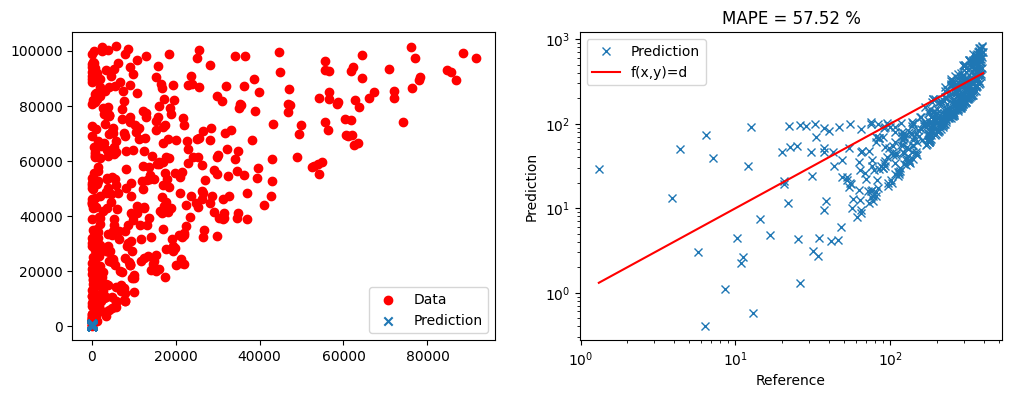

In [35]:
mape_matrix_wavelengthmoreheight = np.zeros((200, 200))
for i in range(200):
    for j in range(200):
        mape_matrix_wavelengthmoreheight[i, j] = linear_network(data_wavelengthmoreheight["x0"], data_wavelengthmoreheight["x1"], [i/1000 - 0.1, j/1000 - 0.1], data_wavelengthmoreheight["x2"])[3]
        
min_mape_wavelengthmoreheight = np.where(mape_matrix_wavelengthmoreheight == np.min(mape_matrix_wavelengthmoreheight))
print(f"Minimum MAPE value is {np.min(mape_matrix_wavelengthmoreheight)} at w0 = {min_mape_wavelengthmoreheight[0][0]/1000 - 0.1} and w1 = {min_mape_wavelengthmoreheight[1][0]/1000 - 0.1}")
fit_and_validate([min_mape_wavelengthmoreheight[0][0]/1000 - 0.1, min_mape_wavelengthmoreheight[1][0]/1000 - 0.1], data_wavelengthmoreheight, data_wavelengthmoreheight, linear_network)


In [20]:
mape_matrix_unswapped = np.zeros((200, 200))
data_renamed = data_swapped.rename(columns={"height": "x0", "wave_length": "x1", "speed": "x2"})
data_renamed.head()

,x0,x1,x2,x0,x1,x2
0,78599.688827,1927.337789,54.855918,78599.688827,1927.337789,54.855918
1,3508.728292,15221.672338,145.873054,15221.672338,3508.728292,145.873054
2,86448.282139,16151.549318,158.800426,86448.282139,16151.549318,158.800426
3,91334.040209,47468.784789,272.237925,91334.040209,47468.784789,272.237925
4,77957.635081,29367.526137,214.130362,77957.635081,29367.526137,214.130362


In [26]:

for i in range(50):
    for j in range(50):
        mape_matrix_unswapped[i, j] = linear_network(data_renamed["x0"], data_renamed["x1"], [i/100 - 0.2, j/100 - 0.2], data_renamed["x2"])[3]
        
# display the data
print(mape_matrix_unswapped)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [24]:

# Get the coordinates of the minimum value of mape
min_mape_unswapped = np.where(mape_matrix_unswapped == np.min(mape_matrix_unswapped))
print(f"Minimum MAPE value is {np.min(mape_matrix_unswapped)} at w0 = {min_mape[0][0]/100 - 0.2} and w1 = {min_mape[1][0]/100 - 0.2}")

fit_and_validate([min_mape_unswapped[0][0]/100 - 0.2, min_mape_unswapped[1][0]/100 - 0.2], data_renamed, data_renamed, linear_network)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

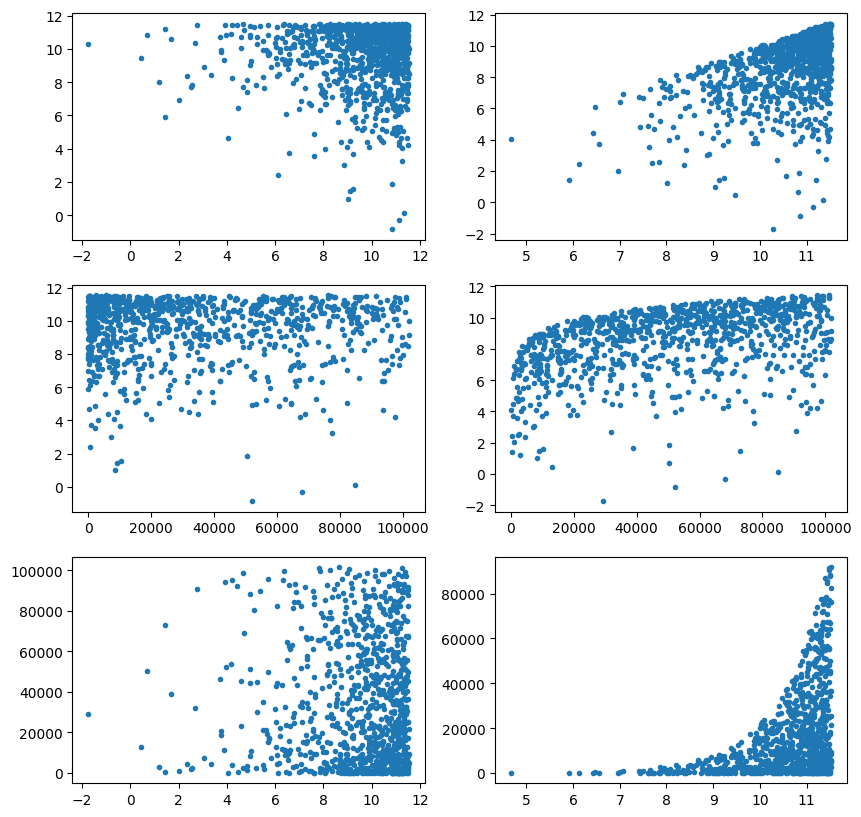

In [6]:
# Perhaps, the data is better represented in a log-log scale
plt.figure(figsize = [10, 10])
# Create a subplot
plt.subplot(3,2 , 1)
plt.plot(np.log(data["height"]), np.log(data["wave_length"]), '.', ls="")
plt.subplot(3,2 , 2)
plt.plot(np.log(data_swapped["x0"]), np.log(data_swapped["x1"]), '.', ls="")
plt.subplot(3,2 , 3)
# Plot the figure with a nat-log scale
plt.plot(data["height"], np.log(data["wave_length"]), '.', ls="")
plt.subplot(3,2 , 4)
plt.plot(data_swapped["x0"], np.log(data_swapped["x1"]), '.', ls="")
# Plot the figure with a log-nat scale
plt.subplot(3,2 , 5)
plt.plot(np.log(data["height"]), data["wave_length"], '.', ls="")
plt.subplot(3,2 , 6)
plt.plot(np.log(data_swapped["x0"]), data_swapped["x1"], '.', ls="")
